## Import a Bunch of Stuff

In [1]:
import codecs
import random
import math
import torch
import itertools
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pickle

use_cuda = torch.cuda.is_available()
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## Define all the Classes & Functions

In [2]:
def load_data(fpath, label, max_story_length):
    data = []
    with codecs.open(fpath, 'r', 'utf-8', errors='ignore') as f:
        lines = f.readlines()
        for l in lines:
            l = l.rstrip()
            data.append((l.split(' ')[0:max_story_length], label))
    return data

class Net(nn.Module):
    def __init__(self, vocab_size, embd_size, out_chs, filter_heights):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embd_size)
        # nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...
        self.conv = nn.ModuleList([nn.Conv2d(1, out_chs, (fh, embd_size)) for fh in filter_heights])
        self.dropout = nn.Dropout(.5)
        self.fc1 = nn.Linear(out_chs*len(filter_heights), 1)
        
    def forward(self, x):
        x = self.embedding(x) # (N, seq_len, embd_dim)
        x = x.unsqueeze(1) # (N, Cin, W, embd_dim), insert Channnel-In dim
        # Conv2d
        #    Input : (N,Cin, Hin, Win )
        #    Output: (N,Cout,Hout,Wout) 
        # squeeze(3) means 2D to 1D; (N,Cout,Hout,Wout) -> [(N,Cout,Hout==seq_len)] * len(filter_heights)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.conv]
        # max_pool1d(input, kernel_size, ..
        # (N, Cout, seq_len) --(max_pool1d)--> (N, Cout, 1) --(squeeze(2))--> (N, Cout)
        # [(N, Cout)]  len(filter_heights)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1) # (N, Cout*len(filter_heights))
        x = self.dropout(x)
        x = self.fc1(x)
        probs = F.sigmoid(x)
        
        return probs

def train(model, data, batch_size, n_epoch):
    model.train() # Sets the module in training mode. This has any effect only on modules such as Dropout or BatchNorm.
    if use_cuda:
        model.cuda()
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    for epoch in range(n_epoch):
        epoch_loss = 0.0
        random.shuffle(data)
        for i in range(0, len(data)-batch_size, batch_size): # discard some last elements
            in_data, labels = [], []
            for sentence, label in data[i: i+batch_size]:
                index_vec = [w2i[w] for w in sentence]
                pad_len = max(0, max_sentence_len - len(index_vec))
                index_vec += [0] * pad_len
                index_vec = index_vec[:max_sentence_len] ## TBD for same len
                in_data.append(index_vec)
                labels.append(label)
            sent_var = Variable(torch.LongTensor(in_data))
            if use_cuda: sent_var = sent_var.cuda()

            target_var = Variable(torch.Tensor(labels).unsqueeze(1))
            if use_cuda: target_var = target_var.cuda()
            optimizer.zero_grad()
            probs = model(sent_var)
            loss = F.binary_cross_entropy(probs, target_var)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.data[0]
        #print('epoch: {:d}, loss: {:.3f}'.format(epoch, epoch_loss))
        losses.append(epoch_loss)
    #print('Training avg loss: {:.3f}'.format(sum(losses)/len(losses)))
        
    return model, losses

def test(model, data, n_test, min_sentence_len):
    model.eval()
    loss = 0
    correct = 0
    for sentence, label in data[:n_test]:
        if len(sentence) < min_sentence_len:  # to short for CNN's filter
            continue
        index_vec = [w2i[w] for w in sentence]
        sent_var = Variable(torch.LongTensor([index_vec]))
        if use_cuda: sent_var = sent_var.cuda()
        out = model(sent_var)
        score = out.data[0][0]
        pred = 1 if score > .5 else 0
        if pred == label:
            correct += 1
        else:
            pass
            #print(sentence)
        loss += math.pow((label-score), 2)
    print('Test acc: {:.3f} ({:d}/{:d})'.format(correct/n_test, correct, n_test))
    #print('Test loss: {:.3f}'.format(loss/n_test))
    
    return correct/n_test

def param_accuracy_graph(out_ch, embd_size, filters):
        
    batch_size = 256
    n_epoch = 25
    params = []
    accuracy = []
    
    model_num = 0
    total_models = len(out_ch)*len(embd_size)*len(filters)
    
    for out_ch, embd_size, filters in itertools.product(out_ch, embd_size, filters):
        
        model_num = model_num + 1
        print("Model {}/{}  {:.1f}%".format(model_num, total_models, model_num*100/total_models))
        
        model = Net(vocab_size, embd_size, out_ch, filters)
        model, losses = train(model, train_data, batch_size, n_epoch)
        accuracy.append(test(model, test_data, len(test_data), max(filters)))
        
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())
        params.append(sum([np.prod(p.size()) for p in model_parameters]))
        
    return params,accuracy

class Parameter:
    def __init__(self, value):
            self.value = value

    def set(self, value):
            self.value = value

    def __call__(self):
            return self.value

def fit(function, parameters, y, x = None):
    def f(params):
        i = 0
        for p in parameters:
            p.set(params[i])
            i += 1
        return y - function(x)

    if x is None: x = np.arange(y.shape[0])
    p = [param() for param in parameters]
    return optimize.leastsq(f, p)

## Load & Preprocess Data

In [8]:
human = load_data('./dataset/stories/fusionModel_humanStories2.txt', 1, 150)
machine = load_data('./dataset/stories/fusionModel_machineStories2_20PercentHuman.txt', 0, 150)
data = human + machine

max_sentence_len = max([len(sentence) for sentence, _ in data])
print('sentence maxlen', max_sentence_len)

vocab = []
for d, _ in data:
    for w in d:
        if w not in vocab: vocab.append(w)
            
vocab = sorted(vocab)
vocab_size = len(vocab)
print('vocab examples:', vocab[:10])
print('vocab size', len(vocab))

w2i = {w:i for i,w in enumerate(vocab)}
i2w = {i:w for i,w in enumerate(vocab)}

# split data into train and test data
div_idx = (int)(len(data) * 0.8)
random.shuffle(data)
train_data = data[:div_idx]
test_data = data[div_idx:]
print('n_train', len(train_data))
print('n_test', len(test_data))

sentence maxlen 150
vocab examples: ['!', '#', '$', '%', '&', "'", "''", "''*So", "''*Well", "''And"]
vocab size 52771
n_train 24221
n_test 6056


## Code that Actually Does Stuff
### Turned into a function to do multiple things while I'm away

In [9]:
def score_generator(modelType, iterations):
    
    while iterations > 0:
        
        ############# Train and Test a bunch of Discriminators #############
        ############# Sort and Save the Param/Accuracy Data    #############

        out_ch = [1, 2, 4, 8, 16]
        embd_size = [1, 2, 4, 8, 16, 32, 64, 128]
        filters = [[1], [1,3], [1,3,5]]

        params, accuracy = param_accuracy_graph(out_ch,embd_size,filters)

        now = datetime.datetime.now()

        with open('params_{}_{}_{}.pkl'.format(modelType, iterations, str(now)), 'wb') as f:
            pickle.dump(params, f)

        with open('accuracy_{}_{}_{}.pkl'.format(modelType, iterations, str(now)), 'wb') as f:
            pickle.dump(accuracy, f)

        df1 = pd.DataFrame({"Num Params":params, "Accuracy":accuracy})
        df1.sort_values(by=['Num Params'])
        #values = df1.groupby("Num Params")["Accuracy"].mean()
        values = df1.groupby("Num Params")["Accuracy"].max()


        ############# Fit the Best Fit Curve to the Data #############
        ##############################################################

        # giving initial parameters
        den = Parameter(10000)

        # define your function:
        def f(x): return (max(values)/math.pi)*np.arctan(x/den()) + .5

        # fit! (given that data is an array with the data to fit)
        y = list(values)
        x = list(values.index.values)
        den = fit(f, [den], y, x)[0][0]


        ############# Plot the Data and Best Fit Curve   #############
        ##############################################################

        x_fit = np.linspace(0,max(x),100)
        y_fit = [((max(y)/math.pi)*np.arctan(x/den) + .5) for x in x_fit]

        fig = plt.figure()
        ax1 = fig.add_subplot(111)

        ax1.scatter(x_fit, y_fit, s=7, c='b', marker="s", label='Fit Curve')
        ax1.scatter(params,accuracy, s=7, c='r', marker="o", label='Model Data')
        plt.legend(loc='lower right');


        ############# Calculate the Area above the Curve and #############
        ############# Below the Max Accuracy                 #############

        xint = max(x)
        yint = max(y)
        d = den

        integral_calculated_at_max_params = (-d*yint*np.log(d**2 + xint**2))/(2*math.pi) + (yint*xint*np.arctan((xint/d)))/math.pi + (.5*xint)
        integral_calculated_at_zero = (-d*yint*np.log(d**2 + 0**2))/(2*math.pi) + (yint*0*np.arctan((0/d)))/math.pi + (.5*0)
        integral = integral_calculated_at_max_params - integral_calculated_at_zero
        total_area_zero_to_max_params = yint*xint
        score = total_area_zero_to_max_params - integral

        print("Evaluation Metric:", score)
        
        with open('stats_{}_{}.txt'.format(modelType, str(now)), 'w+') as f:
            f.write("\n")
            f.write("Time: {}  Run: {}".format(now, iterations))
            f.write("Evaluation Metric: {}".format(score))
            f.write("Fit Denominator: {}".format(den))
                
        iterations -= 1

## Code that Actually Does Stuff Now

Model 1/120  0.8%


/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Test acc: 0.605 (3663/6056)
Model 2/120  1.7%
Test acc: 0.632 (3825/6056)
Model 3/120  2.5%
Test acc: 0.705 (4267/6056)
Model 4/120  3.3%
Test acc: 0.671 (4061/6056)
Model 5/120  4.2%
Test acc: 0.638 (3865/6056)
Model 6/120  5.0%
Test acc: 0.733 (4442/6056)
Model 7/120  5.8%
Test acc: 0.708 (4285/6056)
Model 8/120  6.7%
Test acc: 0.843 (5103/6056)
Model 9/120  7.5%
Test acc: 0.740 (4483/6056)
Model 10/120  8.3%
Test acc: 0.496 (3004/6056)
Model 11/120  9.2%
Test acc: 0.770 (4663/6056)
Model 12/120  10.0%
Test acc: 0.837 (5068/6056)
Model 13/120  10.8%
Test acc: 0.777 (4708/6056)
Model 14/120  11.7%
Test acc: 0.832 (5040/6056)
Model 15/120  12.5%
Test acc: 0.881 (5337/6056)
Model 16/120  13.3%
Test acc: 0.796 (4822/6056)
Model 17/120  14.2%
Test acc: 0.884 (5353/6056)
Model 18/120  15.0%
Test acc: 0.901 (5459/6056)
Model 19/120  15.8%
Test acc: 0.620 (3752/6056)
Model 20/120  16.7%
Test acc: 0.875 (5301/6056)
Model 21/120  17.5%
Test acc: 0.885 (5361/6056)
Model 22/120  18.3%
Test acc: 

Test acc: 0.676 (4092/6056)
Model 53/120  44.2%
Test acc: 0.813 (4922/6056)
Model 54/120  45.0%
Test acc: 0.785 (4753/6056)
Model 55/120  45.8%
Test acc: 0.807 (4885/6056)
Model 56/120  46.7%
Test acc: 0.853 (5168/6056)
Model 57/120  47.5%
Test acc: 0.895 (5418/6056)
Model 58/120  48.3%
Test acc: 0.824 (4988/6056)
Model 59/120  49.2%
Test acc: 0.875 (5300/6056)
Model 60/120  50.0%
Test acc: 0.908 (5501/6056)
Model 61/120  50.8%
Test acc: 0.815 (4933/6056)
Model 62/120  51.7%
Test acc: 0.836 (5064/6056)
Model 63/120  52.5%
Test acc: 0.920 (5570/6056)
Model 64/120  53.3%
Test acc: 0.893 (5410/6056)
Model 65/120  54.2%
Test acc: 0.908 (5498/6056)
Model 66/120  55.0%
Test acc: 0.928 (5621/6056)
Model 67/120  55.8%
Test acc: 0.844 (5114/6056)
Model 68/120  56.7%
Test acc: 0.924 (5596/6056)
Model 69/120  57.5%
Test acc: 0.929 (5624/6056)
Model 70/120  58.3%
Test acc: 0.814 (4929/6056)
Model 71/120  59.2%
Test acc: 0.839 (5083/6056)
Model 72/120  60.0%
Test acc: 0.929 (5626/6056)
Model 73/120

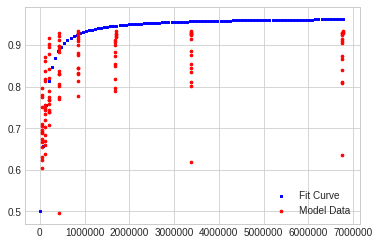

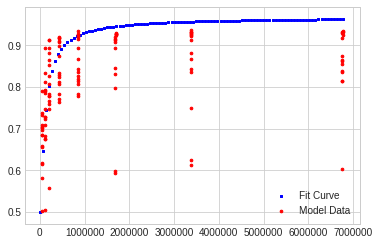

In [10]:
score_generator("fusion20percentHuman", 2)

sentence maxlen 150
vocab examples: ['!', '#', '$', '%', '&', "'", "''", "''*So", "''*Well", "''And"]
vocab size 55755
n_train 24220
n_test 6056
Model 1/120  0.8%


/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Test acc: 0.554 (3352/6056)
Model 2/120  1.7%
Test acc: 0.581 (3521/6056)
Model 3/120  2.5%
Test acc: 0.636 (3852/6056)
Model 4/120  3.3%
Test acc: 0.677 (4102/6056)
Model 5/120  4.2%
Test acc: 0.706 (4274/6056)
Model 6/120  5.0%
Test acc: 0.714 (4322/6056)
Model 7/120  5.8%
Test acc: 0.495 (2997/6056)
Model 8/120  6.7%
Test acc: 0.727 (4402/6056)
Model 9/120  7.5%
Test acc: 0.702 (4249/6056)
Model 10/120  8.3%
Test acc: 0.687 (4162/6056)
Model 11/120  9.2%
Test acc: 0.705 (4267/6056)
Model 12/120  10.0%
Test acc: 0.819 (4957/6056)
Model 13/120  10.8%
Test acc: 0.686 (4153/6056)
Model 14/120  11.7%
Test acc: 0.814 (4932/6056)
Model 15/120  12.5%
Test acc: 0.823 (4984/6056)
Model 16/120  13.3%
Test acc: 0.703 (4258/6056)
Model 17/120  14.2%
Test acc: 0.766 (4636/6056)
Model 18/120  15.0%
Test acc: 0.838 (5075/6056)
Model 19/120  15.8%
Test acc: 0.558 (3378/6056)
Model 20/120  16.7%
Test acc: 0.848 (5138/6056)
Model 21/120  17.5%
Test acc: 0.751 (4546/6056)
Model 22/120  18.3%
Test acc: 

Test acc: 0.628 (3804/6056)
Model 53/120  44.2%
Test acc: 0.672 (4069/6056)
Model 54/120  45.0%
Test acc: 0.740 (4482/6056)
Model 55/120  45.8%
Test acc: 0.673 (4078/6056)
Model 56/120  46.7%
Test acc: 0.816 (4944/6056)
Model 57/120  47.5%
Test acc: 0.855 (5179/6056)
Model 58/120  48.3%
Test acc: 0.707 (4284/6056)
Model 59/120  49.2%
Test acc: 0.861 (5217/6056)
Model 60/120  50.0%
Test acc: 0.855 (5179/6056)
Model 61/120  50.8%
Test acc: 0.710 (4300/6056)
Model 62/120  51.7%
Test acc: 0.879 (5322/6056)
Model 63/120  52.5%
Test acc: 0.872 (5283/6056)
Model 64/120  53.3%
Test acc: 0.744 (4508/6056)
Model 65/120  54.2%
Test acc: 0.870 (5267/6056)
Model 66/120  55.0%
Test acc: 0.876 (5303/6056)
Model 67/120  55.8%
Test acc: 0.746 (4519/6056)
Model 68/120  56.7%
Test acc: 0.869 (5264/6056)
Model 69/120  57.5%
Test acc: 0.892 (5401/6056)
Model 70/120  58.3%
Test acc: 0.707 (4279/6056)
Model 71/120  59.2%
Test acc: 0.850 (5150/6056)
Model 72/120  60.0%
Test acc: 0.886 (5366/6056)
Model 73/120

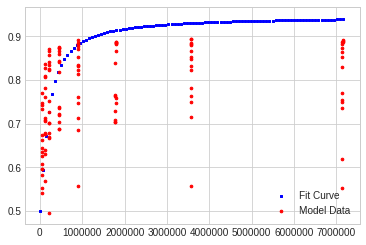

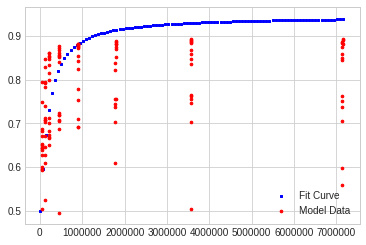

In [11]:
human = load_data('./dataset/stories/fusionModel_humanStories2.txt', 1, 150)
machine = load_data('./dataset/stories/fusionModel_machineStories2_40PercentHuman.txt', 0, 150)
data = human + machine

max_sentence_len = max([len(sentence) for sentence, _ in data])
print('sentence maxlen', max_sentence_len)

vocab = []
for d, _ in data:
    for w in d:
        if w not in vocab: vocab.append(w)
            
vocab = sorted(vocab)
vocab_size = len(vocab)
print('vocab examples:', vocab[:10])
print('vocab size', len(vocab))

w2i = {w:i for i,w in enumerate(vocab)}
i2w = {i:w for i,w in enumerate(vocab)}

# split data into train and test data
div_idx = (int)(len(data) * 0.8)
random.shuffle(data)
train_data = data[:div_idx]
test_data = data[div_idx:]
print('n_train', len(train_data))
print('n_test', len(test_data))

score_generator("fusion40percentHuman", 2)

sentence maxlen 150
vocab examples: ['!', '#', '$', '%', '&', "'", "''", "''*So", "''*Well", "''And"]
vocab size 58426
n_train 24220
n_test 6055
Model 1/120  0.8%


/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Test acc: 0.555 (3361/6055)
Model 2/120  1.7%
Test acc: 0.565 (3421/6055)
Model 3/120  2.5%
Test acc: 0.494 (2990/6055)
Model 4/120  3.3%
Test acc: 0.560 (3392/6055)
Model 5/120  4.2%
Test acc: 0.679 (4110/6055)
Model 6/120  5.0%
Test acc: 0.571 (3458/6055)
Model 7/120  5.8%
Test acc: 0.548 (3319/6055)
Model 8/120  6.7%
Test acc: 0.568 (3437/6055)
Model 9/120  7.5%
Test acc: 0.771 (4668/6055)
Model 10/120  8.3%
Test acc: 0.568 (3442/6055)
Model 11/120  9.2%
Test acc: 0.779 (4718/6055)
Model 12/120  10.0%
Test acc: 0.788 (4769/6055)
Model 13/120  10.8%
Test acc: 0.573 (3469/6055)
Model 14/120  11.7%
Test acc: 0.788 (4771/6055)
Model 15/120  12.5%
Test acc: 0.807 (4885/6055)
Model 16/120  13.3%
Test acc: 0.611 (3698/6055)
Model 17/120  14.2%
Test acc: 0.757 (4585/6055)
Model 18/120  15.0%
Test acc: 0.730 (4423/6055)
Model 19/120  15.8%
Test acc: 0.492 (2982/6055)
Model 20/120  16.7%
Test acc: 0.724 (4386/6055)
Model 21/120  17.5%
Test acc: 0.734 (4443/6055)
Model 22/120  18.3%
Test acc: 

Test acc: 0.594 (3595/6055)
Model 53/120  44.2%
Test acc: 0.738 (4470/6055)
Model 54/120  45.0%
Test acc: 0.779 (4716/6055)
Model 55/120  45.8%
Test acc: 0.599 (3624/6055)
Model 56/120  46.7%
Test acc: 0.770 (4665/6055)
Model 57/120  47.5%
Test acc: 0.780 (4723/6055)
Model 58/120  48.3%
Test acc: 0.639 (3871/6055)
Model 59/120  49.2%
Test acc: 0.812 (4915/6055)
Model 60/120  50.0%
Test acc: 0.806 (4879/6055)
Model 61/120  50.8%
Test acc: 0.631 (3819/6055)
Model 62/120  51.7%
Test acc: 0.834 (5051/6055)
Model 63/120  52.5%
Test acc: 0.833 (5043/6055)
Model 64/120  53.3%
Test acc: 0.818 (4955/6055)
Model 65/120  54.2%
Test acc: 0.790 (4786/6055)
Model 66/120  55.0%
Test acc: 0.830 (5025/6055)
Model 67/120  55.8%
Test acc: 0.627 (3796/6055)
Model 68/120  56.7%
Test acc: 0.831 (5030/6055)
Model 69/120  57.5%
Test acc: 0.835 (5057/6055)
Model 70/120  58.3%
Test acc: 0.642 (3888/6055)
Model 71/120  59.2%
Test acc: 0.816 (4943/6055)
Model 72/120  60.0%
Test acc: 0.829 (5021/6055)
Model 73/120

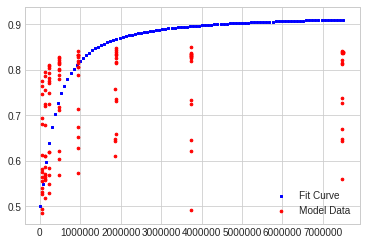

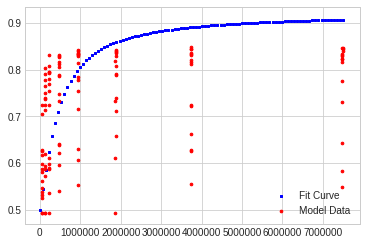

In [12]:
human = load_data('./dataset/stories/fusionModel_humanStories2.txt', 1, 150)
machine = load_data('./dataset/stories/fusionModel_machineStories2_60PercentHuman.txt', 0, 150)
data = human + machine

max_sentence_len = max([len(sentence) for sentence, _ in data])
print('sentence maxlen', max_sentence_len)

vocab = []
for d, _ in data:
    for w in d:
        if w not in vocab: vocab.append(w)
            
vocab = sorted(vocab)
vocab_size = len(vocab)
print('vocab examples:', vocab[:10])
print('vocab size', len(vocab))

w2i = {w:i for i,w in enumerate(vocab)}
i2w = {i:w for i,w in enumerate(vocab)}

# split data into train and test data
div_idx = (int)(len(data) * 0.8)
random.shuffle(data)
train_data = data[:div_idx]
test_data = data[div_idx:]
print('n_train', len(train_data))
print('n_test', len(test_data))

score_generator("fusion60percentHuman", 2)

sentence maxlen 150
vocab examples: ['!', '#', '$', '%', '&', "'", "''", "''*So", "''*Well", "''*You"]
vocab size 60872
n_train 24111
n_test 6028
Model 1/120  0.8%


/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Test acc: 0.503 (3031/6028)
Model 2/120  1.7%
Test acc: 0.523 (3152/6028)
Model 3/120  2.5%
Test acc: 0.759 (4573/6028)
Model 4/120  3.3%
Test acc: 0.528 (3185/6028)
Model 5/120  4.2%
Test acc: 0.727 (4382/6028)
Model 6/120  5.0%
Test acc: 0.755 (4551/6028)
Model 7/120  5.8%
Test acc: 0.503 (3030/6028)
Model 8/120  6.7%
Test acc: 0.541 (3261/6028)
Model 9/120  7.5%
Test acc: 0.754 (4546/6028)
Model 10/120  8.3%
Test acc: 0.538 (3242/6028)
Model 11/120  9.2%
Test acc: 0.761 (4585/6028)
Model 12/120  10.0%
Test acc: 0.762 (4592/6028)
Model 13/120  10.8%
Test acc: 0.531 (3199/6028)
Model 14/120  11.7%
Test acc: 0.759 (4577/6028)
Model 15/120  12.5%
Test acc: 0.767 (4625/6028)
Model 16/120  13.3%
Test acc: 0.555 (3348/6028)
Model 17/120  14.2%
Test acc: 0.758 (4567/6028)
Model 18/120  15.0%
Test acc: 0.762 (4591/6028)
Model 19/120  15.8%
Test acc: 0.524 (3159/6028)
Model 20/120  16.7%
Test acc: 0.764 (4604/6028)
Model 21/120  17.5%
Test acc: 0.767 (4625/6028)
Model 22/120  18.3%
Test acc: 

Test acc: 0.517 (3119/6028)
Model 53/120  44.2%
Test acc: 0.532 (3206/6028)
Model 54/120  45.0%
Test acc: 0.763 (4600/6028)
Model 55/120  45.8%
Test acc: 0.527 (3178/6028)
Model 56/120  46.7%
Test acc: 0.770 (4644/6028)
Model 57/120  47.5%
Test acc: 0.779 (4696/6028)
Model 58/120  48.3%
Test acc: 0.535 (3225/6028)
Model 59/120  49.2%
Test acc: 0.763 (4602/6028)
Model 60/120  50.0%
Test acc: 0.782 (4711/6028)
Model 61/120  50.8%
Test acc: 0.561 (3383/6028)
Model 62/120  51.7%
Test acc: 0.782 (4713/6028)
Model 63/120  52.5%
Test acc: 0.778 (4688/6028)
Model 64/120  53.3%
Test acc: 0.554 (3341/6028)
Model 65/120  54.2%
Test acc: 0.794 (4785/6028)
Model 66/120  55.0%
Test acc: 0.792 (4776/6028)
Model 67/120  55.8%
Test acc: 0.564 (3402/6028)
Model 68/120  56.7%
Test acc: 0.783 (4721/6028)
Model 69/120  57.5%
Test acc: 0.795 (4793/6028)
Model 70/120  58.3%
Test acc: 0.740 (4462/6028)
Model 71/120  59.2%
Test acc: 0.796 (4797/6028)
Model 72/120  60.0%
Test acc: 0.786 (4737/6028)
Model 73/120

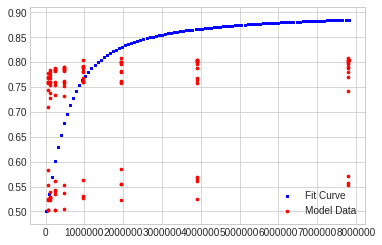

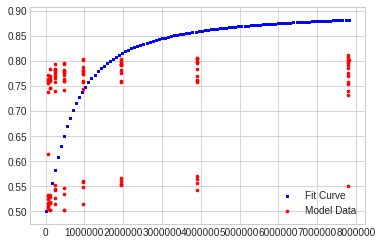

In [13]:
human = load_data('./dataset/stories/fusionModel_humanStories2.txt', 1, 150)
machine = load_data('./dataset/stories/fusionModel_machineStories2_80PercentHuman.txt', 0, 150)
data = human + machine

max_sentence_len = max([len(sentence) for sentence, _ in data])
print('sentence maxlen', max_sentence_len)

vocab = []
for d, _ in data:
    for w in d:
        if w not in vocab: vocab.append(w)
            
vocab = sorted(vocab)
vocab_size = len(vocab)
print('vocab examples:', vocab[:10])
print('vocab size', len(vocab))

w2i = {w:i for i,w in enumerate(vocab)}
i2w = {i:w for i,w in enumerate(vocab)}

# split data into train and test data
div_idx = (int)(len(data) * 0.8)
random.shuffle(data)
train_data = data[:div_idx]
test_data = data[div_idx:]
print('n_train', len(train_data))
print('n_test', len(test_data))

score_generator("fusion80percentHuman", 2)

sentence maxlen 150
vocab examples: ['!', '#', '$', '%', '&', "'", "''", "''*So", "''*Well", "''*You"]
vocab size 63202
n_train 24516
n_test 6130
Model 1/120  0.8%


/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Test acc: 0.508 (3113/6130)
Model 2/120  1.7%
Test acc: 0.757 (4640/6130)
Model 3/120  2.5%
Test acc: 0.511 (3133/6130)
Model 4/120  3.3%
Test acc: 0.511 (3133/6130)
Model 5/120  4.2%
Test acc: 0.787 (4826/6130)
Model 6/120  5.0%
Test acc: 0.783 (4798/6130)
Model 7/120  5.8%
Test acc: 0.510 (3125/6130)
Model 8/120  6.7%
Test acc: 0.782 (4795/6130)
Model 9/120  7.5%
Test acc: 0.781 (4785/6130)
Model 10/120  8.3%
Test acc: 0.511 (3133/6130)
Model 11/120  9.2%
Test acc: 0.507 (3110/6130)
Model 12/120  10.0%
Test acc: 0.753 (4618/6130)
Model 13/120  10.8%
Test acc: 0.511 (3133/6130)
Model 14/120  11.7%
Test acc: 0.784 (4804/6130)
Model 15/120  12.5%
Test acc: 0.784 (4804/6130)
Model 16/120  13.3%
Test acc: 0.511 (3133/6130)
Model 17/120  14.2%
Test acc: 0.783 (4802/6130)
Model 18/120  15.0%
Test acc: 0.794 (4869/6130)
Model 19/120  15.8%
Test acc: 0.511 (3133/6130)
Model 20/120  16.7%
Test acc: 0.794 (4869/6130)
Model 21/120  17.5%
Test acc: 0.795 (4872/6130)
Model 22/120  18.3%
Test acc: 

Test acc: 0.511 (3134/6130)
Model 53/120  44.2%
Test acc: 0.511 (3133/6130)
Model 54/120  45.0%
Test acc: 0.797 (4887/6130)
Model 55/120  45.8%
Test acc: 0.514 (3150/6130)
Model 56/120  46.7%
Test acc: 0.786 (4816/6130)
Model 57/120  47.5%
Test acc: 0.794 (4866/6130)
Model 58/120  48.3%
Test acc: 0.510 (3129/6130)
Model 59/120  49.2%
Test acc: 0.792 (4852/6130)
Model 60/120  50.0%
Test acc: 0.792 (4853/6130)
Model 61/120  50.8%
Test acc: 0.511 (3133/6130)
Model 62/120  51.7%
Test acc: 0.787 (4826/6130)
Model 63/120  52.5%
Test acc: 0.784 (4803/6130)
Model 64/120  53.3%
Test acc: 0.784 (4805/6130)
Model 65/120  54.2%
Test acc: 0.781 (4786/6130)
Model 66/120  55.0%
Test acc: 0.792 (4853/6130)
Model 67/120  55.8%
Test acc: 0.794 (4869/6130)
Model 68/120  56.7%
Test acc: 0.792 (4852/6130)
Model 69/120  57.5%
Test acc: 0.786 (4818/6130)
Model 70/120  58.3%
Test acc: 0.507 (3106/6130)
Model 71/120  59.2%
Test acc: 0.790 (4841/6130)
Model 72/120  60.0%
Test acc: 0.786 (4816/6130)
Model 73/120

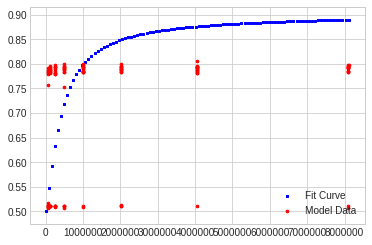

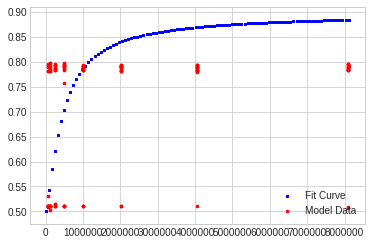

In [14]:
human = load_data('./dataset/stories/fusionModel_humanStories2.txt', 1, 150)
machine = load_data('./dataset/stories/fusionModel_machineStories2_100PercentHuman.txt', 0, 150)
data = human + machine

max_sentence_len = max([len(sentence) for sentence, _ in data])
print('sentence maxlen', max_sentence_len)

vocab = []
for d, _ in data:
    for w in d:
        if w not in vocab: vocab.append(w)
            
vocab = sorted(vocab)
vocab_size = len(vocab)
print('vocab examples:', vocab[:10])
print('vocab size', len(vocab))

w2i = {w:i for i,w in enumerate(vocab)}
i2w = {i:w for i,w in enumerate(vocab)}

# split data into train and test data
div_idx = (int)(len(data) * 0.8)
random.shuffle(data)
train_data = data[:div_idx]
test_data = data[div_idx:]
print('n_train', len(train_data))
print('n_test', len(test_data))

score_generator("fusion100percentHuman", 2)